# ROBERTA model for predicting nouns

In [1]:
import pandas as pd
import transformers
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import torch
import logging
import warnings

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.20.0

numpy       : 1.19.2
pandas      : 1.2.2
torch       : 1.8.1+cu111
transformers: 4.4.2



In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

device

if device == 'cuda':
    gpu_server = True # in case we run the notebook on Colab, set it to False

In [4]:
if gpu_server == True:
    df = pd.read_csv('data/semcor_df.csv')
else:
    df = pd.read_csv('/content/drive/MyDrive/semcor_belli/semcor_df.csv')
    
df.head()

,Unnamed: 0,text|@id,text|sentence|@id,text|sentence|instance,text|sentence|instance|@id,text|sentence|instance|@lemma,text|sentence|instance|@pos,lexelt|sense|@id,lexelt|@item,lexelt|@pos,lexelt|@sence_count_wn,lexelt|@sense_count_corpus,lexelt|@word_example_count,lexelt|sense|@gloss,lexelt|sense|@sense_example_count,lexelt|sense|@sense_freq,lexelt|sense|@synset,sentences
0,0,d000,d000.s000,long,d000.s000.t000,long,ADJ,long%3:00:02::,long#a,a,9,3,193,primarily temporal sense; being or indicating ...,102,118,long,How long has it been since you reviewed the ob...
1,1,d000,d000.s000,been,d000.s000.t001,be,VERB,be%2:42:03::,be#v,v,13,11,15783,"have the quality of being; (copula, used with ...",10088,10742,be,How long has it been since you reviewed the ob...
2,2,d000,d000.s000,reviewed,d000.s000.t002,review,VERB,review%2:31:00::,review#v,v,5,3,22,look at again; examine again,12,13,review reexamine,How long has it been since you reviewed the ob...
3,3,d000,d000.s000,objectives,d000.s000.t003,objective,NOUN,objective%1:09:00::,objective#n,n,2,1,38,the goal intended to be attained (and which is...,38,38,aim object objective target,How long has it been since you reviewed the ob...
4,4,d000,d000.s000,benefit,d000.s000.t004,benefit,NOUN,benefit%1:21:00::,benefit#n,n,3,3,31,financial assistance in time of need,16,16,benefit,How long has it been since you reviewed the ob...


In [5]:
check = df['text|sentence|instance|@pos'].value_counts()
check

VERB    88098
NOUN    86668
ADJ     31673
ADV     18941
Name: text|sentence|instance|@pos, dtype: int64

Come ottimizzare (taglio concetti o taglio parole). Selezioni su set concetti + comuni. 

In [6]:
df = df.drop(df[df['text|sentence|instance|@pos'] == 'VERB'].index)
df = df.drop(df[df['text|sentence|instance|@pos'] == 'ADJ'].index)
df = df.drop(df[df['text|sentence|instance|@pos'] == 'ADV'].index)
#df = df.drop(df[df['text|sentence|instance|@pos'] == 'NOUN'].index)
#df = df.drop(df[df['text|sentence|instance'] != 'have'].index)

In [7]:
df.shape

(86668, 18)

In [8]:
df1 = df.drop(['Unnamed: 0','text|@id','text|sentence|@id','text|sentence|instance','text|sentence|instance|@pos',
                   'lexelt|@item','lexelt|@pos','lexelt|@sence_count_wn','lexelt|@sense_count_corpus','lexelt|@word_example_count',
                   'lexelt|sense|@gloss','lexelt|sense|@sense_example_count','lexelt|sense|@sense_freq','lexelt|sense|@synset'],
                  axis=1)
df1

,text|sentence|instance|@id,text|sentence|instance|@lemma,lexelt|sense|@id,sentences
3,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...
4,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...
5,d000.s000.t005,service,service%1:04:07::,How long has it been since you reviewed the ob...
6,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...
9,d000.s001.t002,giveaway,giveaway%1:21:00::,Have you permitted it to become a giveaway pro...
...,...,...,...,...
220309,d183.s068.t000,person,person%1:03:00::,Kate 's all right''.
220310,d183.s088.t000,vacation,vacation%1:28:00::,"Well, we 're taking a little vacation, that 's..."
220314,d183.s138.t000,person,person%1:03:00::,`` How 's Scotty''?
220315,d185.s034.t000,plunker,plunker%1:04:00::,No plunkers for him''.


In [9]:
#df_sent = df_sent.set_index(df_sent['text|sentence|instance|@id'])
#df_sent

In [10]:
df2 = df1.rename(columns = {'lexelt|sense|@id': 'target'})

In [11]:
df2

,text|sentence|instance|@id,text|sentence|instance|@lemma,target,sentences
3,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...
4,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...
5,d000.s000.t005,service,service%1:04:07::,How long has it been since you reviewed the ob...
6,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...
9,d000.s001.t002,giveaway,giveaway%1:21:00::,Have you permitted it to become a giveaway pro...
...,...,...,...,...
220309,d183.s068.t000,person,person%1:03:00::,Kate 's all right''.
220310,d183.s088.t000,vacation,vacation%1:28:00::,"Well, we 're taking a little vacation, that 's..."
220314,d183.s138.t000,person,person%1:03:00::,`` How 's Scotty''?
220315,d185.s034.t000,plunker,plunker%1:04:00::,No plunkers for him''.


In [12]:
df2 = df2.reset_index(drop=True)

In [13]:
df2

,text|sentence|instance|@id,text|sentence|instance|@lemma,target,sentences
0,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...
1,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...
2,d000.s000.t005,service,service%1:04:07::,How long has it been since you reviewed the ob...
3,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...
4,d000.s001.t002,giveaway,giveaway%1:21:00::,Have you permitted it to become a giveaway pro...
...,...,...,...,...
86663,d183.s068.t000,person,person%1:03:00::,Kate 's all right''.
86664,d183.s088.t000,vacation,vacation%1:28:00::,"Well, we 're taking a little vacation, that 's..."
86665,d183.s138.t000,person,person%1:03:00::,`` How 's Scotty''?
86666,d185.s034.t000,plunker,plunker%1:04:00::,No plunkers for him''.


In [14]:
item_counts = df2["target"].value_counts()
item_counts

person%1:03:00::            6696
group%1:03:00::             1328
location%1:03:00::           989
man%1:18:00::                429
year%1:28:01::               409
                            ... 
inclination%1:25:02::          1
psychopomp%1:18:00::           1
switch-hitter%1:18:00::        1
ebbing%1:22:00::               1
implementation%1:04:00::       1
Name: target, Length: 15875, dtype: int64

In [15]:
df2.isna().sum() 

text|sentence|instance|@id       0
text|sentence|instance|@lemma    0
target                           0
sentences                        0
dtype: int64

In [16]:
df2 = df2.groupby('target').filter(lambda x: len(x) >= 10)
df2

,text|sentence|instance|@id,text|sentence|instance|@lemma,target,sentences
0,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...
1,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...
3,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...
5,d000.s001.t003,program,program%1:09:01::,Have you permitted it to become a giveaway pro...
6,d000.s001.t006,goal,goal%1:09:00::,Have you permitted it to become a giveaway pro...
...,...,...,...,...
86661,d179.s025.t000,person,person%1:03:00::,`` What about Ballestre''?
86662,d179.s027.t000,person,person%1:03:00::,`` Precious.
86663,d183.s068.t000,person,person%1:03:00::,Kate 's all right''.
86664,d183.s088.t000,vacation,vacation%1:28:00::,"Well, we 're taking a little vacation, that 's..."


In [17]:
df2.dtypes

text|sentence|instance|@id       object
text|sentence|instance|@lemma    object
target                           object
sentences                        object
dtype: object

In [18]:
item_counts = df2["text|sentence|instance|@lemma"].value_counts()
item_counts

person        6696
group         1328
location       989
man            566
time           493
              ... 
consumer        10
safety          10
oil             10
regulation      10
prospect        10
Name: text|sentence|instance|@lemma, Length: 1352, dtype: int64

In [19]:
df2 = df2.reset_index(drop=True)

In [20]:
df2.isna().sum() 

text|sentence|instance|@id       0
text|sentence|instance|@lemma    0
target                           0
sentences                        0
dtype: int64

In [21]:
#df3 = df2.iloc[:1000]

In [22]:
#df3.head()

In [23]:
#filtered.isna().sum() 

In [24]:
df2["target"] = df2["target"].astype('category')
df2.dtypes

text|sentence|instance|@id         object
text|sentence|instance|@lemma      object
target                           category
sentences                          object
dtype: object

In [25]:
df2["target_enc"] = df2["target"].cat.codes
df2.head()

,text|sentence|instance|@id,text|sentence|instance|@lemma,target,sentences,target_enc
0,d000.s000.t003,objective,objective%1:09:00::,How long has it been since you reviewed the ob...,1011
1,d000.s000.t004,benefit,benefit%1:21:00::,How long has it been since you reviewed the ob...,135
2,d000.s000.t006,program,program%1:09:01::,How long has it been since you reviewed the ob...,1201
3,d000.s001.t003,program,program%1:09:01::,Have you permitted it to become a giveaway pro...,1201
4,d000.s001.t006,goal,goal%1:09:00::,Have you permitted it to become a giveaway pro...,644


In [26]:
#df2.dtypes

In [27]:
new_data = pd.DataFrame()
new_data['text'] = df2['sentences']
new_data['labels'] = df2['target_enc']

In [28]:
new_data.head()

,text,labels
0,How long has it been since you reviewed the ob...,1011
1,How long has it been since you reviewed the ob...,135
2,How long has it been since you reviewed the ob...,1201
3,Have you permitted it to become a giveaway pro...,1201
4,Have you permitted it to become a giveaway pro...,644


In [29]:
new_data.dtypes

text      object
labels     int16
dtype: object

<AxesSubplot:>

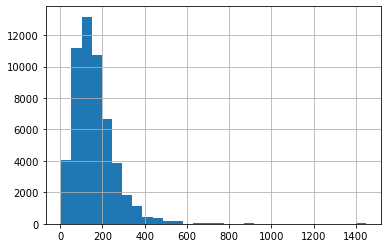

In [30]:
sentences = [len(sent) for sent in new_data['text']]
pd.Series(sentences).hist(bins=30)

### CLEANING AND NLP ANALYSIS OF TEXT DATA

In [31]:
for index,text in enumerate(new_data['text'][400:410]):
  print('Sentence %d:\n'%(index),text) #300:305

Sentence 0:
 He had to look for other prospects, other motives until more conclusive evidence pointing to Johnston came to light.
Sentence 1:
 Madden, with his investigation centered on the fraud, said that tomorrow he would go to the Bronx bank through which Mrs. Meeker 's checks to Johnston had cleared.
Sentence 2:
 Madden, with his investigation centered on the fraud, said that tomorrow he would go to the Bronx bank through which Mrs. Meeker 's checks to Johnston had cleared.
Sentence 3:
 Madden, with his investigation centered on the fraud, said that tomorrow he would go to the Bronx bank through which Mrs. Meeker 's checks to Johnston had cleared.
Sentence 4:
 Madden, with his investigation centered on the fraud, said that tomorrow he would go to the Bronx bank through which Mrs. Meeker 's checks to Johnston had cleared.
Sentence 5:
 Madden, with his investigation centered on the fraud, said that tomorrow he would go to the Bronx bank through which Mrs. Meeker 's checks to Johnsto

In [32]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import re
import string

import numpy as np
import pandas as pd # For visualizations
import matplotlib.pyplot as plt # For regular expressions
import re # For handling string
import string # For performing mathematical operations
import math

In [33]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","aren't": "are not",   
                     "can't": "cannot","can't've": "cannot have","'s":"is","'m":"am","'re":"are",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","'scuse":" excuse" }

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the plots
new_data['text']=new_data['text'].apply(lambda x:expand_contractions(x))

In [34]:
new_data['text']=new_data['text'].apply(lambda x: x.lower())
new_data['text']=new_data['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
new_data['text']=new_data['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [35]:
for index,text in enumerate(new_data['text'][400:410]):
  print('Sentence %d:\n'%(index),text)

Sentence 0:
 he had to look for other prospects other motives until more conclusive evidence pointing to johnston came to light
Sentence 1:
 madden with his investigation centered on the fraud said that tomorrow he would go to the bronx bank through which mrs meeker is checks to johnston had cleared
Sentence 2:
 madden with his investigation centered on the fraud said that tomorrow he would go to the bronx bank through which mrs meeker is checks to johnston had cleared
Sentence 3:
 madden with his investigation centered on the fraud said that tomorrow he would go to the bronx bank through which mrs meeker is checks to johnston had cleared
Sentence 4:
 madden with his investigation centered on the fraud said that tomorrow he would go to the bronx bank through which mrs meeker is checks to johnston had cleared
Sentence 5:
 madden with his investigation centered on the fraud said that tomorrow he would go to the bronx bank through which mrs meeker is checks to johnston had cleared
Sentenc

In [36]:
#CHECK = set(new_data["text"])
#print(len(CHECK))   #17696 different sentences in the dataset 

In [37]:
#nlp = spacy.load('en_core_web_sm')
#text = list(new_data["text"])
#doc = str(text) 
#doc1 = nlp(doc)          #NLP PART ON GOOGLE COLAB 

<AxesSubplot:>

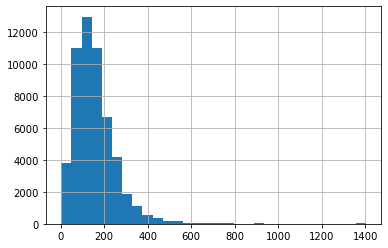

In [38]:
sentences = [len(sent) for sent in new_data['text']]
pd.Series(sentences).hist(bins=30)

In [39]:
print(new_data['labels'].max())

1728


### THE MODEL

In [40]:
warnings.simplefilter('ignore')
logging.basicConfig(level=logging.ERROR)

In [41]:
from transformers import RobertaTokenizer

In [42]:
import cv2

In [43]:
 cv2.__version__

'4.5.1'

In [44]:
MAX_LEN = 200 #or 300 (depends)
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE  = 64
VALID_BATCH_SIZE = 64
LEARNING_RATE = 2e-5
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [45]:
from torch.utils.data import Dataset

class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long) #long
        }

In [46]:
train_size = 0.75
test_size  = 0.60

train_data = new_data.sample(frac=train_size,random_state=200)
eval_data  = new_data.drop(train_data.index)#.reset_index(drop=True)
test_data  = eval_data.sample(frac=test_size,random_state=200)
val_data   = eval_data.drop(test_data.index)

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)
val_data   = val_data.reset_index(drop=True)



print("FULL Dataset: {}".format(new_data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
print("VALIDATION Dataset: {}".format(val_data.shape))

FULL Dataset: (54069, 2)
TRAIN Dataset: (40552, 2)
TEST Dataset: (8110, 2)
VALIDATION Dataset: (5407, 2)


In [47]:
train_data

,text,labels
0,who is the owner,1043
1,children scoring high in compulsivity were tho...,1393
2,briefly we rolled over a paved road up to pak ...,856
3,mrs horowitz was in charge of diseases of the ...,1567
4,in man the normal level of iodine in the diet ...,771
...,...,...
40547,by bc the aegean was an area of common tongue...,350
40548,he would cross to manhattan to harlem heights ...,951
40549,moreover as communist power increases the enjo...,301
40550,thus the transformation of adam smith is ideal...,398


In [48]:
training_set   = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set    = MultiLabelDataset(test_data, tokenizer, MAX_LEN)
validating_set = MultiLabelDataset(val_data, tokenizer, MAX_LEN)

In [49]:
from torch.utils.data import DataLoader

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader   = DataLoader(training_set, **train_params)
testing_loader    = DataLoader(testing_set, **test_params)
validating_loader = DataLoader(validating_set, **val_params)

In [50]:
#from transformers import DistilBertModel
#
#class DistilBERTClass(torch.nn.Module):
#    def __init__(self):
#        super(DistilBERTClass, self).__init__()
#        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
#        self.pre_classifier = torch.nn.Linear(768, 768)
#        self.dropout = torch.nn.Dropout(0.1)
#        self.classifier = torch.nn.Linear(768, 5485) #24083, #181
#
#    def forward(self, input_ids, attention_mask, token_type_ids):
#        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
#        hidden_state = output_1[0]
#        pooler = hidden_state[:, 0]
#        pooler = self.pre_classifier(pooler)
#        pooler = torch.nn.Tanh()(pooler)
#        pooler = self.dropout(pooler)
#        output = self.classifier(pooler)
#        return output
#
#model = DistilBERTClass()
#model.to(device)

from transformers import RobertaModel

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        #self.classifier_hid = torch.nn.Linear(768, 1512)
        #self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 1729)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        #pooler = self.classifier_hid(pooler)
        #pooler = self.dropout(pooler)
        #pooler = torch.nn.ReLU()(pooler)
        output = self.classifier(pooler)
        return output

model = RoBERTaClass()
model.to(device)

RoBERTaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [51]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples): #scheduler,
    model = model.train() 
    losses = []
    correct_predictions = 0
    
    for _,data in enumerate(data_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask, token_type_ids)
        
        _, preds = torch.max(outputs.data, dim=1) #max
        loss = loss_fn(outputs, targets) # get loss
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for _,data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            
            _, preds = torch.max(outputs.data, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses) 

In [53]:
import shutil
from collections import defaultdict

def train_model(model, data_loaders_train, data_loader_test, train_sizes, test_sizes, device, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.001)
    loss_fn   = torch.nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(model, training_loader, loss_fn, 
                                            optimizer, device, scheduler, train_data.shape[0]) #scheduler,
        
        print(f'Train loss {train_loss}, accuracy {train_acc}') #accuracy {train_acc}
        
        val_acc, val_loss = eval_model(model, testing_loader, loss_fn, device, test_data.shape[0])
        
        print(f'Val loss {val_loss}, accuracy {val_acc}') # accuracy {val_acc}
        print()
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            
    print(f'Best val accuracy: {best_accuracy}')
    
    model.load_state_dict(torch.load('best_model_state.bin'))
    
    return model, history

In [54]:
%%time

base_model, history = train_model(model, training_loader, testing_loader, train_data.shape[0], test_data.shape[0],
                                  device, n_epochs=20)

Epoch 1/20
----------
Train loss 6.557614467121449, accuracy 0.1268987966068258
Val loss 6.189224532270056, accuracy 0.1409371146732429

Epoch 2/20
----------
Train loss 5.986697509085718, accuracy 0.15089268100217004
Val loss 5.739165542632576, accuracy 0.16646115906288533

Epoch 3/20
----------
Train loss 5.564307567072968, accuracy 0.17708127835865062
Val loss 5.416635610925869, accuracy 0.18668310727496917

Epoch 4/20
----------
Train loss 5.230245818099013, accuracy 0.19986683764056026
Val loss 5.163879999025601, accuracy 0.20221948212083846

Epoch 5/20
----------
Train loss 4.944898972751966, accuracy 0.2201864273032156
Val loss 4.969417147749052, accuracy 0.20900123304562268

Epoch 6/20
----------
Train loss 4.7318246202890055, accuracy 0.23547543894259224
Val loss 4.9656818720299425, accuracy 0.2091245376078915

Epoch 7/20
----------
Train loss 4.739911933050546, accuracy 0.2340205168672322
Val loss 4.962469780538965, accuracy 0.20974106041923551

Epoch 8/20
----------
Train lo

In [55]:
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

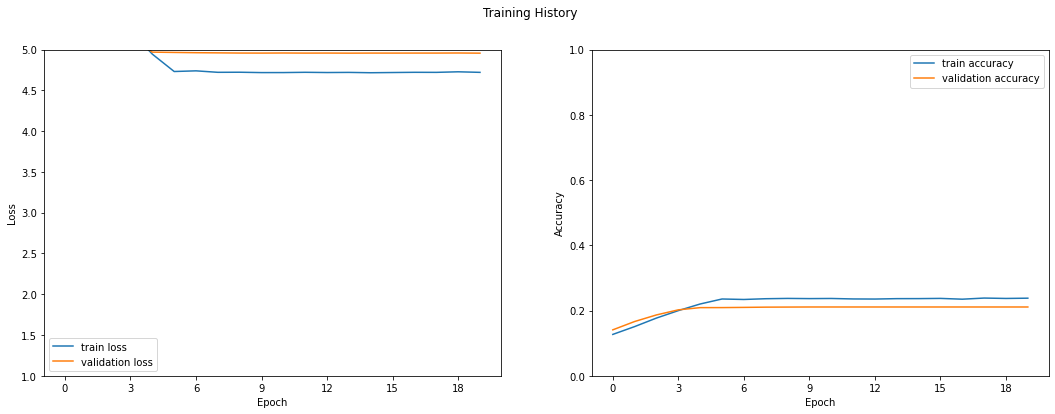

In [56]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([1.00,5.00])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([0.00,1.00])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    
    fig.suptitle('Training History')
    
plot_training_history(history)

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

In [58]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for _,data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            
            _, preds = torch.max(outputs.data, 1)
            predictions.extend(preds)
            real_values.extend(targets)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    
    return predictions, real_values

y_pred, y_test = get_predictions(model, validating_loader)

In [59]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          14       0.22      0.40      0.29         5
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         4
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         5
          20       0.00    